<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TSA_Gold_ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group - 8
CH24M548 - Mounika Chowdary Pamulapati

CH24M571 - Soumya Mukherjee

CH24M577 - Surya Kandala

Dataset : Gold.csv


Steps followed :
1. **Importing the dataset** :
2. **Cleaning the dataset**: Ensured that missing dates were added and forward fill of the data for the missing dates. Dropped NaN records whereever observed.
3. **Stationartiy Check**: Validated if the timeseries is stationary or not by performing ADF and KSS test. For ADF test if p<0.05, then it says the timeseries is stationary. If p>0.05 for KSS test, it indicates the timeseries is stationary.

4. **First Order Differencing & Log Differencing:** Performing first order differencing to make the timeseries stationary.
5. **ACF and PACF:** Compute Auto Correlation and Partial correlation to understand the presence of MA and AR components.
6. **Power Spectral Density:** For a process to be stationary, both mean and variance need to be independent of the absolute time. Hence, validating if Variance is dependent on the absolute time.
7. **Random Walk:** Based on the ACF and PACF values, going with ARMA model of 010 since ACF and PACF results indicate complete white noise.
8. **Akaike's Information Criteria:** Since the forecast is only a straight line, checked the AIC values for models starting from 000 till 332. Chose that model which has less AIC value
9. **Train, Test & Generate Forecast:** Generated the forecast for 122 model which got less AIC value in step 7.
10. **MSE, RMSE, MAPE:** Identify the Mean Square Error and Root Mean Square Error to check the residual details.
11. **Alternate Non-Lionear models:** Since we have variance as a function of absolute time, linear models might not be the right choice to move ahead, hence trying out the non-linear models ARCH and GARCH to model the data.


--- Starting off by installing dependecies ---


In [ ]:
!pip install pandas seaborn matplotlib

Import dependencies

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Use winget to get the data

In [3]:
# Downloading the dataset
!wget 'https://drive.google.com/uc?export=download&id=1cXGNQ3NtUERYHbP5Jm4fmZR1jmd2M9ME' -O Gold.csv

--2024-12-26 20:11:57--  https://drive.google.com/uc?export=download&id=1cXGNQ3NtUERYHbP5Jm4fmZR1jmd2M9ME
Resolving drive.google.com (drive.google.com)... 142.251.163.139, 142.251.163.100, 142.251.163.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.163.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1cXGNQ3NtUERYHbP5Jm4fmZR1jmd2M9ME&export=download [following]
--2024-12-26 20:11:57--  https://drive.usercontent.google.com/download?id=1cXGNQ3NtUERYHbP5Jm4fmZR1jmd2M9ME&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.115.132, 2607:f8b0:4004:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.115.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95758 (94K) [application/octet-stream]
Saving to: ‘Gold.csv’

Gold.csv            100%[===================>]  93.51K  --.-KB/s   

In [13]:
# Load the dataset
try:
    gold_data = pd.read_csv('Gold.csv')
except FileNotFoundError:
    print("Error: 'Gold.csv' not found. Please make sure the file exists and the path is correct.")
    exit()

Dividing the data into test train split using scikit learn . The train_test_split() method is used to split our data into train and test sets.

In [27]:

#gold_data = gold_data.set_index('DATE')  # setting DATE as the index column
# thinking back we dont really need to index using date as it is a string , can differ .. better to index using natural cell order


display(gold_data.head(20))

# Divide the data into training and testing sets (80:20 split)
train_data, test_data = train_test_split(
        gold_data,
        test_size=0.2,
        shuffle=False
        ) # shuffle=False to maintain time order

# Write the training and testing sets to new CSV files, overwriting if they exist
train_data.to_csv('training.csv', index=False) #index=False to avoid writing row indices
test_data.to_csv('test.csv', index=False) #index=False to avoid writing row indices



,DATE,VALUE
0,1995-01-03,381.40
1,1995-01-04,378.25
2,1995-01-05,375.00
3,1995-01-06,375.90
4,1995-01-09,372.45
5,1995-01-10,374.10
6,1995-01-11,375.00
7,1995-01-12,377.60
8,1995-01-13,379.80
9,1995-01-16,377.45


In [28]:
# printing training and test data (maybe just for fun /s)

try:
    train_df = pd.read_csv('training.csv')
    test_df = pd.read_csv('test.csv')
    print("Training Data:")
    print(train_df.head())
    print("\nTest Data:")
    print(test_df.head())
except FileNotFoundError:
    print("Error: 'training.csv' or 'test.csv' not found.")
except Exception as e:
  print("Other exceptions occurred")

Training Data:
         DATE   VALUE
0  1995-01-03  381.40
1  1995-01-04  378.25
2  1995-01-05  375.00
3  1995-01-06  375.90
4  1995-01-09  372.45

Test Data:
         DATE    VALUE
0  2012-07-02  1596.25
1  2012-07-03  1608.50
2  2012-07-04  1617.00
3  2012-07-05  1616.75
4  2012-07-06  1591.75


Now that the data is divided , we want to fill in the missing values .
There is a couple of choices we considered to fill the missing values > 1. Forward fill vs 2 . Linear interpolation .

The data will turn out as follows :
 Let's say gold closed at $1900 on Friday and opened at $1920 on Monday

Forward fill would show:
 - Friday: $1900
 - Saturday: $1900 [same price held]
 - Sunday: $1900 [same price held ]
 - Monday: $1920 [sudden jump]

Linear interpolation would show:
- Friday: $1900
- Saturday: $1906.67 [gradual increase]
- Sunday: $1913.33 [ gradual increase ]
- Monday: $1920

Financial markets hold the closing prices from Friday and show the same values on Saturday and Sunday . Thus forward fill would be most appropriate

In [29]:
copied_train_df = train_df.copy()
# Convert 'DATE' column to datetime objects
copied_train_df['DATE'] = pd.to_datetime(copied_train_df['DATE'])

# Create a complete date range
date_rng = pd.date_range(start=copied_train_df['DATE'].min(), end=copied_train_df['DATE'].max())
complete_date_df = pd.DataFrame({'DATE': date_rng})

# Merge the complete date range with the training data
copied_train_df = pd.merge(complete_date_df, copied_train_df, on='DATE', how='left')

# Forward fill the 'VALUE' column
copied_train_df['VALUE'] = copied_train_df['VALUE'].ffill()

# Select only the 'DATE' and 'VALUE' columns
copied_train_df = copied_train_df[['DATE', 'VALUE']]

# Save the adjusted training data to a new CSV file
copied_train_df.to_csv('training_adjusted.csv', index=False)



Print first 20 values from training df and adjusted training df

In [30]:
try:
    train_df_adjusted = pd.read_csv('training_adjusted.csv')
    print("Training Data:")
    print(train_df.head(20))
    print("\n Training Adjusted Data:")
    print(train_df_adjusted.head(20))
except FileNotFoundError:
    print("Error: 'training.csv' or 'training_adjusted.csv' not found.")
except Exception as e:
  print("Other exceptions occurred")

Training Data:
          DATE   VALUE
0   1995-01-03  381.40
1   1995-01-04  378.25
2   1995-01-05  375.00
3   1995-01-06  375.90
4   1995-01-09  372.45
5   1995-01-10  374.10
6   1995-01-11  375.00
7   1995-01-12  377.60
8   1995-01-13  379.80
9   1995-01-16  377.45
10  1995-01-17  377.90
11  1995-01-18  382.00
12  1995-01-19  383.10
13  1995-01-20  383.00
14  1995-01-23  385.10
15  1995-01-24  381.50
16  1995-01-25  381.70
17  1995-01-26  380.50
18  1995-01-27  380.00
19  1995-01-30  375.90

 Training Adjusted Data:
          DATE   VALUE
0   1995-01-03  381.40
1   1995-01-04  378.25
2   1995-01-05  375.00
3   1995-01-06  375.90
4   1995-01-07  375.90
5   1995-01-08  375.90
6   1995-01-09  372.45
7   1995-01-10  374.10
8   1995-01-11  375.00
9   1995-01-12  377.60
10  1995-01-13  379.80
11  1995-01-14  379.80
12  1995-01-15  379.80
13  1995-01-16  377.45
14  1995-01-17  377.90
15  1995-01-18  382.00
16  1995-01-19  383.10
17  1995-01-20  383.00
18  1995-01-21  383.00
19  1995-01-22  

Now that values are continuous , we shall try to plot DATE vs VALUE using seaborn

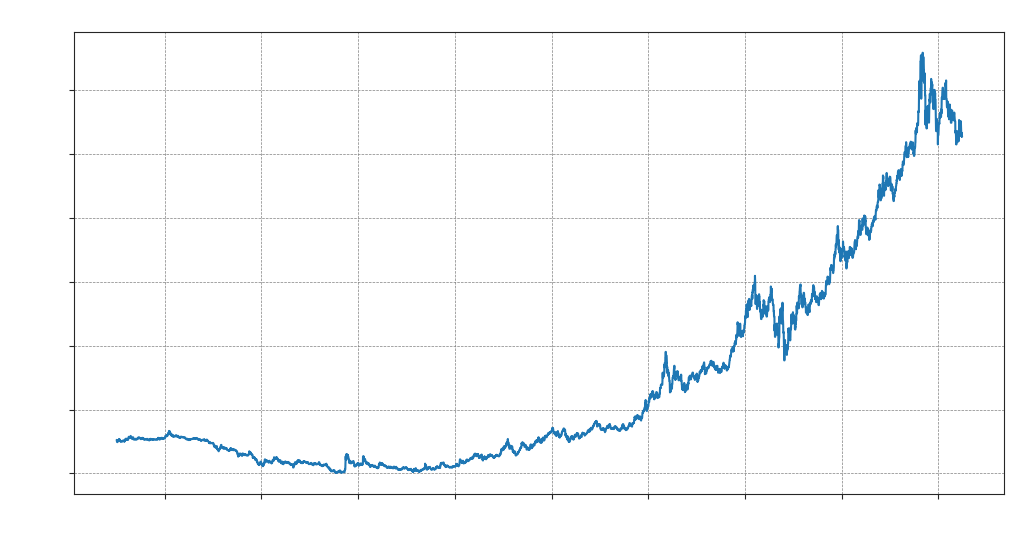

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'DATE' column to datetime objects
train_df_adjusted['DATE'] = pd.to_datetime(train_df_adjusted['DATE'])

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.set_style("ticks") # Set background style : More here https://www.geeksforgeeks.org/seaborn-style-and-color/

# Plot DATE vs VALUE
sns.lineplot(x='DATE', y='VALUE', data=train_df_adjusted)
plt.xlabel("Date", color='white') # Set x-axis label color
plt.ylabel("Value", color='white')  # Set y-axis label color
plt.title("Date vs. Value", color='white') # Set plot title color
plt.xticks(color='white') # Set x-axis ticks color
plt.yticks(color='white') # Set y-axis ticks color
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()